In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets

import scienceplots
plt.style.use(['science', 'no-latex'])

In [25]:
def response(W, B, dI):
    """
    W : weight matrix
    I : input (dI)
    B: diagonal matrix of cellular gains
    """

    if np.linalg.det(B) == 0:
        # print("Matrix B is singular, cannot compute its inverse.")
        return np.nan, np.nan
    
    A = np.linalg.inv(B) - W

    if np.linalg.det(A) == 0:
        # print("Matrix A is singular, cannot compute its inverse.")
        return np.nan, np.nan
    R = np.linalg.inv(A)
    
    R_l = R[0] @ dI
    R_e = R[1] @ dI

    return R_l, R_e

def determinant(W, B):
    """
    Compute the determinant of the matrix A = inv(B) - W
    where B is the diagonal matrix of cellular gains
    and W is the weight matrix
    
    This determinant is the denominator of the response functions
    """
    if np.linalg.det(B) == 0:
        # print("Matrix B is singular, cannot compute its inverse.")
        return np.nan
    A = np.linalg.inv(B) - W
    det = np.linalg.det(A)
    return det

def dynamics(W, I, tau=np.ones(4), dt=0.01, duration=5):
    """
    Compute the dynamics of the system given by:
    dR/dt = -R + f(WR + I)
    where f is the linear transfer function with gain B
    """

    r = np.zeros((W.shape[0], int(duration/dt)))

    for t in range(1, r.shape[1]):
        r[:, t] = r[:, t-1] + (dt/tau) * (-r[:, t-1] + transfer_function(W @ r[:, t-1] + I))

    return r

    
def transfer_function(input):
    output = (1/4) * input**2
    return output

def ext_input(bg_l, bg_e, bg_p, bg_c, duration, dt, t_on, amp, tau_l, tau_e, tau_p, tau_c):
    """
    create the external input vector as a numpy array
    where at specified time, the input increases from baseline to a higher value
    in an exponentially decaying manner
    """

    n_steps = int(duration/dt)
    t_on = int(t_on/dt)
    I = np.zeros((4, int(duration/dt)))

    for t in range(n_steps):
        if t >= t_on:
            I[0, t] = bg_l + amp * (1 - np.exp(-(t - t_on)/tau_l))
            I[1, t] = bg_e + amp * (1 - np.exp(-(t - t_on)/tau_e))
            I[2, t] = bg_p + amp * (1 - np.exp(-(t - t_on)/tau_p))
            I[3, t] = bg_c + amp * (1 - np.exp(-(t - t_on)/tau_c))
        else:
            I[0, t] = bg_l
            I[1, t] = bg_e
            I[2, t] = bg_p
            I[3, t] = bg_c

    return I

def ext_input_const(bg_l=1, bg_e=1, bg_p=1, bg_c=1):
    """
    create the external input vector as a numpy array
    where the input is constant
    """

    I = np.array([bg_l, bg_e, bg_p, bg_c], dtype=float)

    return I

def ss_gain(W, r_ss, I, a=1/4*np.ones(4), b=2*np.ones(4)):
    """
    Compute the steady state gain of the system
    given the weight matrix W and the steady state rates r, and the input to the system I

    assumes that the transfer function = f(input) = (input^2)/4
    """
    B_ss = np.diag(a*b*((W @ r_ss + I)**(b-1)))
    return B_ss

def response_regime_metric(R_l, R_e):
    """
    Compute the response regime metric
    defined as the ratio of the change in R_e to the change in R_l
    """

    if R_l > 0 and R_e > 0: # training
        return 0
    elif R_l > 0 and R_e <= 0: # early recall
        return 1
    elif R_l <= 0 and R_e > 0: # late recall
        return 2
    else: # no response
        return 3
    

(4, 500)


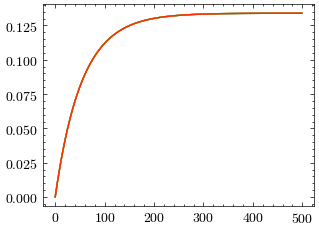

In [3]:
# plot dynamics for sanity check
# --- IGNORE ---
# --- IGNORE ---
J = 1.0
g = 2.0
W = np.array([[J, J, -g*J, -g*J],
              [J, J, -g*J, -g*J],
              [J, J, -g*J, -g*J],
              [J, J, -g*J, -g*J]])
input = ext_input_const()
r = dynamics(W, input, duration=5)
print(r.shape)
plt.plot(r.T)
# --- IGNORE ---
# --- IGNORE ---    

In [4]:
# Connectivity no - 1

def exc_vs_inh_simple(J, g, I_l, I_e, I_p, I_c, a=1/4*np.ones(4), b=2*np.ones(4)):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        all inhibitory weights : g*J
    """
    W = np.array([[J, J, -g*J, -g*J],
                  [J, J, -g*J, -g*J],
                  [J, J, -g*J, -g*J],
                  [J, J, -g*J, -g*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input, a, b)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det

# Connectivity no - 2

def inh_PV_CCK(J, g_p, g_c, I_l, I_e , I_p, I_c, a=1/4*np.ones(4), b=2*np.ones(4)):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        inhibitory weights from PV : g_p*J
        inhibitory weights from CCK : g_c*J
    """
    W = np.array([[J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input, a, b)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det

# Connectivity no - 3
def inh_PV_diff(J, g_p, g_c, alpha_p, beta_p, I_l, I_e, I_p, I_c, a =1/4*np.ones(4), b=2*np.ones(4)):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        PV inhibitory weights : g_p*J
            - to late born exc neurons : alpha_p*g_p*J
            - to early born exc neurons : beta_p*g_p*J
        CCK inhibitory weights : g_c*J
    """
    W = np.array([[J, J, -alpha_p*g_p*J, -g_c*J],
                  [J, J, -beta_p*g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input, a, b)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det

# Connectivity no - 4
def inh_CCK_diff(J, g_p, g_c, alpha_c, beta_c, I_l, I_e, I_p, I_c, a=1/4*np.ones(4), b=2*np.ones(4)):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        PV inhibitory weights : g_p*J
        CCK inhibitory weights : g_c*J
            - to late born exc neurons : alpha_c*g_c*J
            - to early born exc neurons : beta_c*g_c*J
    """
    W = np.array([[J, J, -g_p*J, -alpha_c*g_c*J],
                  [J, J, -g_p*J, -beta_c*g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input, a, b)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det

# Connectivity no - 5
def inh_PV_diff_CCK_diff(J, g_p, g_c, alpha_p, beta_p, alpha_c, beta_c, I_l, I_e, I_p, I_c, a=1/4*np.ones(4), b=2*np.ones(4)):
    """
    4 populations: LB, EB, PV, CCK
        all excitatory weights : J
        PV inhibitory weights : g_p*J
            - to late born exc neurons : alpha_p*g_p*J
            - to early born exc neurons : beta_p*g_p*J
        CCK inhibitory weights : g_c*J
            - to late born exc neurons : alpha_c*g_c*J
            - to early born exc neurons : beta_c*g_c*J
    """
    W = np.array([[J, J, -alpha_p*g_p*J, -alpha_c*g_c*J],
                  [J, J, -beta_p*g_p*J, -beta_c*g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J]])
    
    # simulate dynamics
    input = ext_input_const()
    r = dynamics(W, input)
    r_ss = r[:, -1]
    # infer the steady state gain
    B = ss_gain(W, r_ss, input, a, b)

    # compute the response functions
    dI = np.array([I_l, I_e, I_p, I_c])
    R_l, R_e = response(W, B, dI)
    det = determinant(W, B)

    return R_l, R_e, det


In [5]:
# explore connectivity no - 1
@widgets.interact(I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                  v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1))
def explore_exc_vs_inh_simple(I_l, I_e, I_p, I_c, v_min, v_max):

    J_arr = np.linspace(0, 2, 50)
    g_arr = np.linspace(0, 5, 50)

    R_l = np.zeros((len(J_arr), len(g_arr)))
    R_e = np.zeros((len(J_arr), len(g_arr)))
    determinant_grid = np.zeros((len(J_arr), len(g_arr)))
    response_regime = np.zeros((len(J_arr), len(g_arr)))

    for i, J in enumerate(J_arr):
        for j, g in enumerate(g_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = exc_vs_inh_simple(J, g, I_l, I_e, I_p, I_c)
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)
    im1 = ax[0].imshow(determinant_grid.T, extent=[J_arr[0], J_arr[-1], g_arr[0], g_arr[-1]], origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$J$')
    ax[0].set_ylabel(r'$g$')
    fig.colorbar(im1, ax=ax[0])

    # add dashed white line at determinant = 0
    cx = ax[0].contour(J_arr, g_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'det=0'}, inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=[J_arr[0], J_arr[-1], g_arr[0], g_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[1].set_title(r'$R_l$')
    ax[1].set_xlabel(r'$J$')
    ax[1].set_ylabel(r'$g$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(J_arr, g_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_l=0'}, inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=[J_arr[0], J_arr[-1], g_arr[0], g_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[2].set_title(r'$R_e$')
    ax[2].set_xlabel(r'$J$')
    ax[2].set_ylabel(r'$g$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(J_arr, g_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_e=0'}, inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=[J_arr[0], J_arr[-1], g_arr[0], g_arr[-1]], origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$J$')
    ax[3].set_ylabel(r'$g$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response'])

    fig.suptitle(f'Exc vs Inh simple ($g$ vs $J$)')
    fig.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='I_l', max=2.0, min=-1.0), FloatSlider(value=1.0, des…

In [6]:
# explore connectivity no - 2
@widgets.interact(J = widgets.FloatSlider(value=1, min=0, max=2, step=0.1),
                  I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                    v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1))
def explore_inh_PV_CCK(J, I_l, I_e, I_p, I_c, v_min, v_max):

    g_p_arr = np.linspace(0, 5, 50)
    g_c_arr = np.linspace(0, 5, 50)

    R_l = np.zeros((len(g_p_arr), len(g_c_arr)))
    R_e = np.zeros((len(g_p_arr), len(g_c_arr)))
    determinant_grid = np.zeros((len(g_p_arr), len(g_c_arr)))
    response_regime = np.zeros((len(g_p_arr), len(g_c_arr)))

    for i, g_p in enumerate(g_p_arr):
        for j, g_c in enumerate(g_c_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = inh_PV_CCK(J, g_p, g_c, I_l, I_e, I_p, I_c)
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)
    im1 = ax[0].imshow(determinant_grid.T, extent=[g_p_arr[0], g_p_arr[-1], g_c_arr[0], g_c_arr[-1]], origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$g_p$')
    ax[0].set_ylabel(r'$g_c$')
    fig.colorbar(im1, ax=ax[0])
    # add dashed white line at determinant = 0
    cx = ax[0].contour(g_p_arr, g_c_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'det=0'}, inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=[g_p_arr[0], g_p_arr[-1], g_c_arr[0], g_c_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[1].set_title(r'$R_l$')
    ax[1].set_xlabel(r'$g_p$')
    ax[1].set_ylabel(r'$g_c$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(g_p_arr, g_c_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_l=0'}, inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=[g_p_arr[0], g_p_arr[-1], g_c_arr[0], g_c_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[2].set_title(r'$R_e$')
    ax[2].set_xlabel(r'$g_p$')
    ax[2].set_ylabel(r'$g_c$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(g_p_arr, g_c_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_e=0'}, inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=[g_p_arr[0], g_p_arr[-1], g_c_arr[0], g_c_arr[-1]], origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$g_p$')
    ax[3].set_ylabel(r'$g_c$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response'])

    fig.suptitle(f'Inh PV and CCK ($g_p$ vs $g_c$)')
    fig.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='J', max=2.0), FloatSlider(value=1.0, description='I_…

In [7]:
# Exploring connectivity no - 3
@widgets.interact(J = widgets.FloatSlider(value=1, min=0, max=2, step=0.1),
                  g_p = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  g_c = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                  v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1),
                  a_e = widgets.FloatSlider(value=1/4, min=0.1, max=1, step=0.05))
def explore_inh_PV_diff(J, g_p, g_c, I_l, I_e, I_p, I_c, v_min, v_max, a_e):
    
    alpha_p_arr = np.linspace(0, 4, 50)
    beta_p_arr = np.linspace(0, 4, 50)

    R_l = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    R_e = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    determinant_grid = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    response_regime = np.zeros((len(alpha_p_arr), len(beta_p_arr)))

    for i, alpha_p in enumerate(alpha_p_arr):
        for j, beta_p in enumerate(beta_p_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = inh_PV_diff(J, g_p, g_c, alpha_p, beta_p, I_l, I_e, I_p, I_c, a=np.array([1/4, a_e, 1/4, 1/4]), b=2*np.ones(4))
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)
    im1 = ax[0].imshow(determinant_grid.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$\alpha_p$')
    ax[0].set_ylabel(r'$\beta_p$')
    fig.colorbar(im1, ax=ax[0])
    # add dashed white line at determinant = 0
    cx = ax[0].contour(alpha_p_arr, beta_p_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'det=0'}, inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[1].set_title(r'$R_l$')
    ax[1].set_xlabel(r'$\alpha_p$')
    ax[1].set_ylabel(r'$\beta_p$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(alpha_p_arr, beta_p_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_l=0'}, inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[2].set_title(r'$R_e$')
    ax[2].set_xlabel(r'$\alpha_p$')
    ax[2].set_ylabel(r'$\beta_p$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(alpha_p_arr, beta_p_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_e=0'}, inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$\alpha_p$')
    ax[3].set_ylabel(r'$\beta_p$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response'])

    fig.suptitle(f'Inh PV diff ($\\alpha_p$ vs $\\beta_p$)')
    fig.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='J', max=2.0), FloatSlider(value=1.0, description='g_…

In [ ]:
# Exploring connectivity no - 4
@widgets.interact(J = widgets.FloatSlider(value=1, min=0, max=2, step=0.1),
                  g_p = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  g_c = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                  v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1))
def explore_inh_CCK_diff(J, g_p, g_c, I_l, I_e, I_p, I_c, v_min, v_max):
    
    

interactive(children=(FloatSlider(value=1.0, description='J', max=2.0), FloatSlider(value=1.0, description='g_…

In [ ]:
# Exploring connectivity no - 5

def plot_PV_diff_CCK_diff(J, g_p, g_c, alpha_c, beta_c, I_l, I_e, I_p, I_c, v_min, v_max, savefig=False, location=""):
    
    alpha_p_arr = np.linspace(0, 5, 100)
    beta_p_arr = np.linspace(0, 5, 100)

    R_l = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    R_e = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    determinant_grid = np.zeros((len(alpha_p_arr), len(beta_p_arr)))
    response_regime = np.zeros((len(alpha_p_arr), len(beta_p_arr)))

    for i, alpha_p in enumerate(alpha_p_arr):
        for j, beta_p in enumerate(beta_p_arr):
            R_l[i, j], R_e[i, j], determinant_grid[i, j] = inh_PV_diff_CCK_diff(J, g_p, g_c, alpha_p, beta_p, alpha_c, beta_c, I_l, I_e, I_p, I_c)
            response_regime[i, j] = response_regime_metric(R_l[i, j], R_e[i, j])

    fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200)
    im1 = ax[0].imshow(determinant_grid.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto')
    ax[0].set_title('Determinant')
    ax[0].set_xlabel(r'$\alpha_p$')
    ax[0].set_ylabel(r'$\beta_p$')
    fig.colorbar(im1, ax=ax[0])
    # add dashed white line at determinant = 0
    cx = ax[0].contour(alpha_p_arr, beta_p_arr, determinant_grid.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'det=0'}, inline=True, fontsize=8)

    im2 = ax[1].imshow(R_l.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[1].set_title(r'$R_l$')
    ax[1].set_xlabel(r'$\alpha_p$')
    ax[1].set_ylabel(r'$\beta_p$')
    fig.colorbar(im2, ax=ax[1])
    cx = ax[1].contour(alpha_p_arr, beta_p_arr, R_l.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_l=0'}, inline=True, fontsize=8)

    im3 = ax[2].imshow(R_e.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto', vmin=v_min, vmax=v_max)
    ax[2].set_title(r'$R_e$')
    ax[2].set_xlabel(r'$\alpha_p$')
    ax[2].set_ylabel(r'$\beta_p$')
    fig.colorbar(im3, ax=ax[2])
    cx = ax[2].contour(alpha_p_arr, beta_p_arr, R_e.T, levels=[0], colors='white', linestyles='dashed')
    cx.clabel(fmt={0:'R_e=0'}, inline=True, fontsize=8)

    im4 = ax[3].imshow(response_regime.T, extent=[alpha_p_arr[0], alpha_p_arr[-1], beta_p_arr[0], beta_p_arr[-1]], origin='lower', aspect='auto')
    ax[3].set_title('Response Regime')
    ax[3].set_xlabel(r'$\alpha_p$')
    ax[3].set_ylabel(r'$\beta_p$')
    cbar = fig.colorbar(im4, ax=ax[3], ticks=[0, 1, 2, 3])
    cbar.ax.set_yticklabels(['Training', 'Early Recall', 'Late Recall', 'No Response']) 

    fig.suptitle(f'Inh PV diff and CCK diff ($\\alpha_p$ vs $\\beta_p$)')
    fig.tight_layout()

    if savefig:
        plt.savefig(location + "PV_diff_CCK_diff.svg")
    plt.show()

@widgets.interact(J = widgets.FloatSlider(value=0.8, min=0, max=2, step=0.1),
                  g_p = widgets.FloatSlider(value=0.9, min=0, max=5, step=0.1),
                  g_c = widgets.FloatSlider(value=0.9, min=0, max=5, step=0.1),
                  alpha_c = widgets.FloatSlider(value=1.2, min=0, max=5, step=0.1),
                  beta_c = widgets.FloatSlider(value=1, min=0, max=5, step=0.1),
                  I_l = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_e = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_p = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  I_c = widgets.FloatSlider(value=1, min=-1, max=2, step=0.1),
                  v_min = widgets.FloatSlider(value=-1, min=-10, max=0, step=0.1),
                  v_max = widgets.FloatSlider(value=1, min=0, max=10, step=0.1))
def explore_PV_diff_CCK_diff(J, g_p, g_c, alpha_c, beta_c, I_l, I_e, I_p, I_c, v_min, v_max):
    plot_PV_diff_CCK_diff(J, g_p, g_c, alpha_c, beta_c, I_l, I_e, I_p, I_c, v_min, v_max, savefig=False)

interactive(children=(FloatSlider(value=0.8, description='J', max=2.0), FloatSlider(value=0.9, description='g_…

In [16]:
# list colormaps
print(plt.colormaps())

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'berlin', 'managua', 'vanimo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 't

/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_9860/2321118677.py:55: RuntimeWarning: overflow encountered in square
  output = (1/4) * input**2
/var/folders/g6/7nyb4bzj60n8q754q7qp7z200000gn/T/ipykernel_9860/2321118677.py:49: RuntimeWarning: invalid value encountered in matmul
  r[:, t] = r[:, t-1] + (dt/tau) * (-r[:, t-1] + transfer_function(W @ r[:, t-1] + I))
/Users/divyansh/miniforge3/envs/mean_field/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2430: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


<Figure size 350x262.5 with 0 Axes>

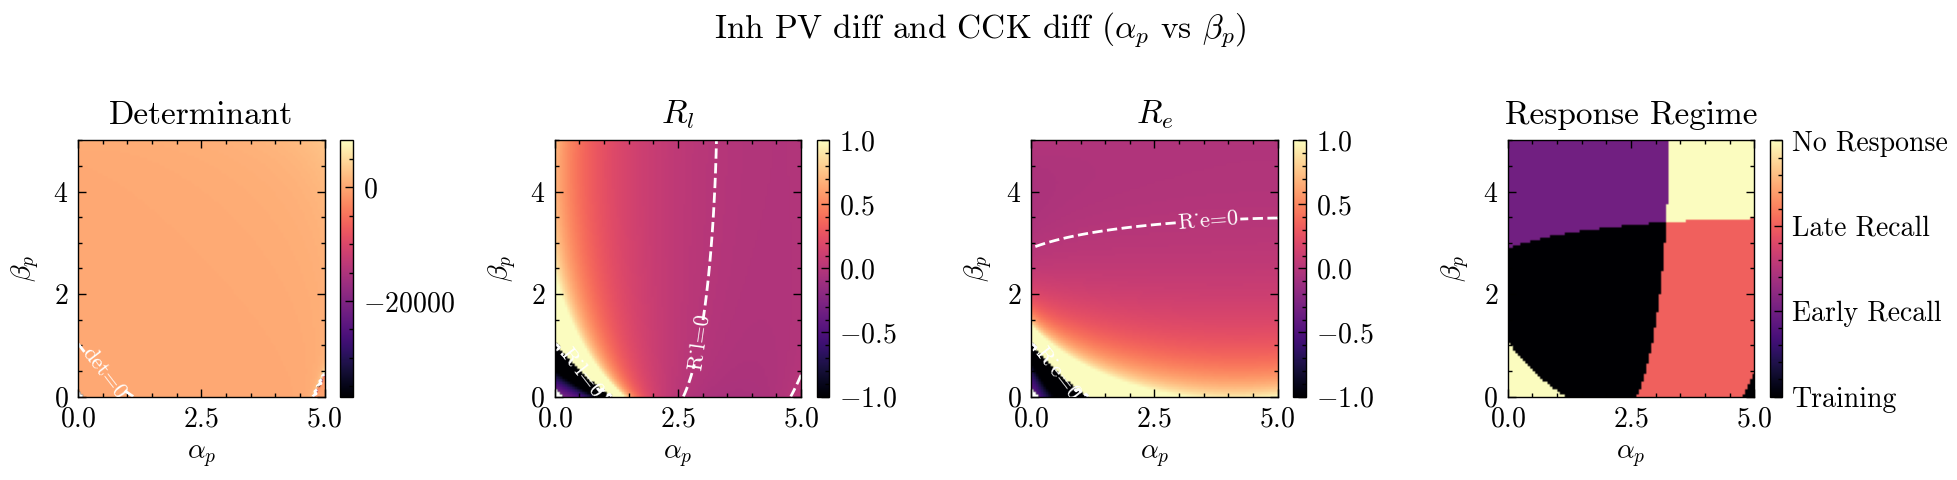

In [19]:
plt.set_cmap('magma')
J = 1.2
g_p = 0.9
g_c = 0.9
alpha_c = 1.2
beta_c = 1
I_l = 1
I_e = 1
I_p = 1
I_c = 1
v_min = -1
v_max = 1
location = "../../results/4_pop_non-linear/diff_inh_PV_CCK/"
plot_PV_diff_CCK_diff(J, g_p, g_c, alpha_c, beta_c, I_l, I_e, I_p, I_c, v_min, v_max, savefig=True, location=location)



In [50]:

def dynamics_plot(J, g_p, g_c, alpha_p, beta_p, alpha_c, beta_c, I_l, I_e, I_p, I_c, duration=10, dt=0.01, savefig=False, location="", label=""):
    W = np.array([[J, J, -alpha_p*g_p*J, -alpha_c*g_c*J],
                  [J, J, -beta_p*g_p*J, -beta_c*g_c*J],
                  [J, J, -g_p*J, -g_c*J],
                  [J, J, -g_p*J, -g_c*J]])
    
    tau = 0.01*np.ones(4)

    r = np.zeros((W.shape[0], int(duration/dt)))
    input = ext_input(I_l, I_e, I_p, I_c, duration=duration, dt=dt, t_on=5, amp=0.2, tau_l=5, tau_e=5, tau_p=5, tau_c=5)

    assert input.shape[1] == r.shape[1], "Input and rate matrix must have the same number of time steps"
    for t in range(1, r.shape[1]):

        r[:, t] = r[:, t-1] + (dt/tau) * (-r[:, t-1] + transfer_function(W @ r[:, t-1] + input[:, t]))


    time = np.arange(0, duration, dt)
    skip = 10
    time = time[skip:]
    r = r[:, skip:]
    plt.figure(figsize=(3, 1.5), dpi=300)
    plt.plot(time, r[0], label='R_l', color='blue')
    plt.plot(time, r[1], label='R_e', color='orange')
    # plt.plot(time, r[2], label='R_p', color='green')
    # plt.plot(time, r[3], label='R_c', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (Hz)')
    plt.title(label)
    plt.legend()

    plt.savefig(location + "dynamics_" + label + ".svg")
    plt.show()

In [51]:
# remove ticks from the plots
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False

# set font size
plt.rcParams.update({'font.size': 12})
# set linewdith
plt.rcParams['lines.linewidth'] = 2

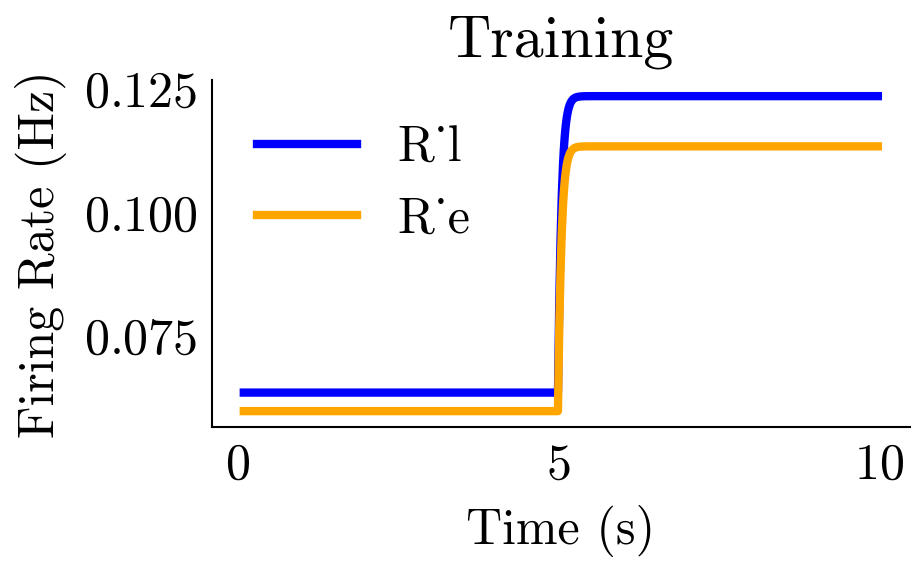

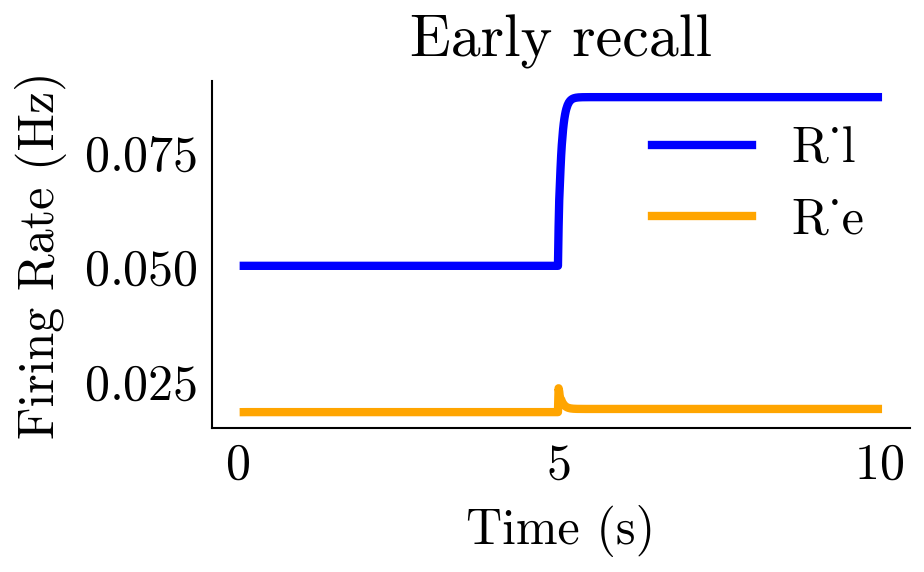

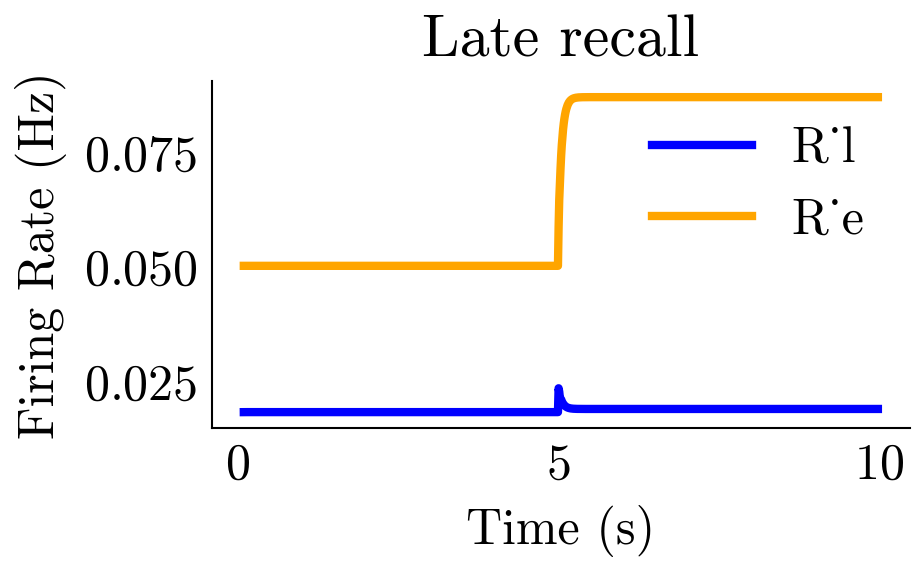

In [52]:
duration = 10
dt = 0.01
J = 1.2
g_p = 1
g_c = 0.9
alpha_c = 1
beta_c = 1
I_l = 0.5
I_e = 0.5
I_p = 0.5
I_c = 0.5



alpha_p = 1.0
beta_p = 1.2


location = "../../results/4_pop_non-linear/diff_inh_PV_CCK/"
dynamics_plot(J, g_p, g_c, alpha_p, beta_p, alpha_c, beta_c, I_l, I_e, I_p, I_c, duration=duration, dt=dt, savefig=True, location=location, label="Training")


alpha_p = 1.2
beta_p = 4


location = "../../results/4_pop_non-linear/diff_inh_PV_CCK/"
dynamics_plot(J, g_p, g_c, alpha_p, beta_p, alpha_c, beta_c, I_l, I_e, I_p, I_c, duration=duration, dt=dt, savefig=True, location=location, label="Early recall")


alpha_p = 4
beta_p = 1.2

location = "../../results/4_pop_non-linear/diff_inh_PV_CCK/"
dynamics_plot(J, g_p, g_c, alpha_p, beta_p, alpha_c, beta_c, I_l, I_e, I_p, I_c, duration=duration, dt=dt, savefig=True, location=location, label="Late recall")

